# Indentificador de ônibus ou caminhão

## Autor

- Pablo Santos Costa
- Matrícula: 180128817
- GitHub: pabloheika

## Objetivo

Este modelo de deep learning tem o propósito treinar os conhecimentos adquiridos na lição 1 de aprendizagem de máquina fazendo a identificação de imagens de ônibus ou caminhões. 

## Preparação

Como pre requisito precisamos garantir a instalação da versão mais recente das bibliotecas ```DuckDuckGo search``` e ```fastai```.

In [12]:
%pip install -U duckduckgo_search
%pip install -U fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Após a instalação das dependências podemos iniciar os passos para a implementação da ia.

## Passo 1: Baixar as imagens dos cítricos

Começamos fazendo as importações necessárias das bibliotecas e definimos uma função para adquirir as imagens do `DuckDcukGo` usando o `ddg_images`.

In [13]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Começamos solicitando a URL referente a imagem de um ônibus:

In [15]:
urls = search_images("Bus", max_images=1)
urls[0]

Searching for 'Bus'


'https://www.sustainable-bus.com/wp-content/uploads/2018/12/IMG_7637.jpg'

Em seguida fazemos o download da imagem encontrada:

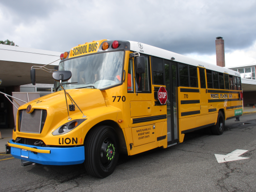

In [16]:
from fastdownload import download_url
dest = 'bus.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

agora baixaremos a foto de um caminhão:

Searching for 'Truck'


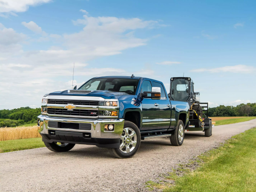

In [19]:
download_url(search_images('Truck', max_images=1)[0], 'truck.jpg', show_progress=False)
Image.open('truck.jpg').to_thumb(256,256)

Temos recebido bons resultados de imagens, e por isso faremos o download de uma série de imagens de ônibus ou caminhão em pastas distintas, teremos pausas de tempo para não sobrecarregar o servidor. Também incrementamos um pouco pesquisando-os em versões grandes e também modernas.

In [20]:
searches = 'Bus', 'Truck'
path = Path('Bus_or_Truck')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} image'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} big image'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} modern image'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Bus image'
Searching for 'Bus big image'
Searching for 'Bus modern image'
Searching for 'Truck image'
Searching for 'Truck big image'
Searching for 'Truck modern image'


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Passo 2: Treinando a inteligência  artificial

Antes de começar o treinamento do modelo devemos verificar e remover as imagens que apresentaram defeitos durante o download, para evitar falhas no modelo.

In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

Para treinar uma IA, é necessário utilizar DataLoaders, que é um objeto que contém um conjunto de treinamento (as imagens usadas para criar uma IA) e um conjunto de validação (as imagens usadas para verificar a precisão de uma IA - não usadas durante o treinamento). No fastai, é possível criar isso facilmente usando o DataBlock e visualizar imagens de exemplos:

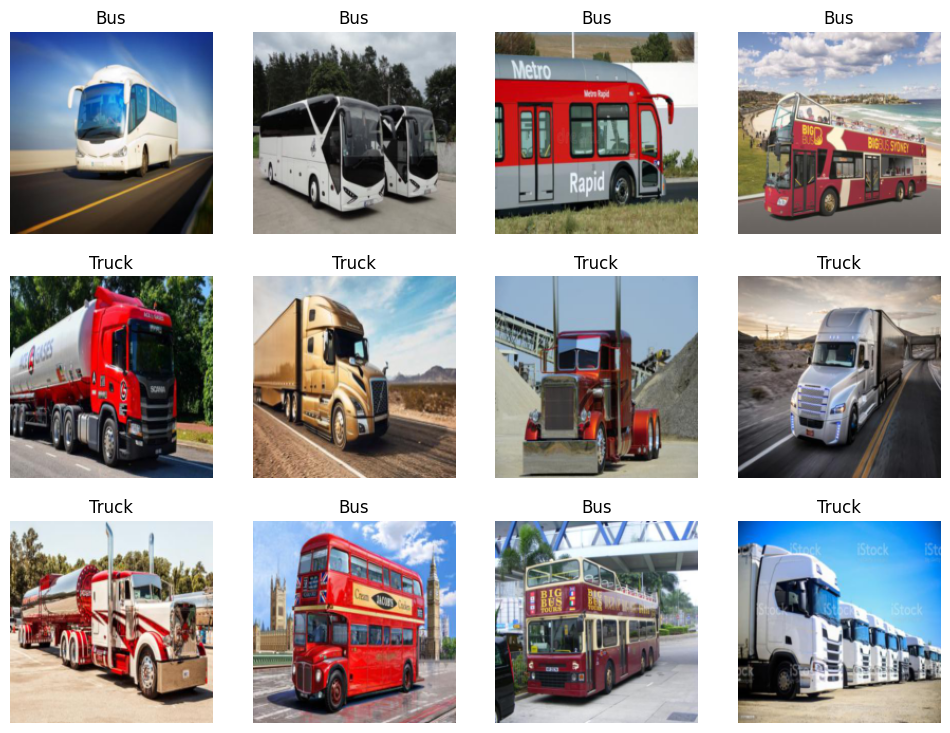

In [22]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Com os preparativos concluídos podemos iniciar o treinamento usando o modelo de visão computacional resnet18 que é o mais popular e rápido atualmente, em poucos minutos se consegue treinar um modelo com ele, até mesmo usando somente CPU, embora o resultado com uma GPU seja significativamente mais veloz. Utilizando o método fine_tune() do fastai geramos um modelo de pré treinamento ajustada automaticamente. 

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.131110,0.885688,0.242424,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.422000,0.420330,0.181818,00:19
1,0.243496,0.201134,0.060606,00:23
2,0.161583,0.113442,0.060606,00:19


## Passo 3: Uso da inteligência artificial

Agora que temos uma ia treinada, vamos ver o que ela acha da primeira imagem de um ônibus que baixamos.

In [24]:
is_bus_photo,_,probs = learn.predict(PILImage.create('bus.jpg'))
print(f"This is a: {is_bus_photo}.")
print(f"Probability it's a bus photo: {probs[0]:.4f}")

This is a: Bus.
Probability it's a bus photo: 0.9988


## Conclusão

podemos notar que mesmo se tratando de auto moveis semelhantes em porte e com grande diversidade de estilos e cores, a ia soube identificar o ônibus com uma ótima precisão probabilística. 